In [1]:
pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import random
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset

from sklearn.model_selection import KFold
from easyfsl.methods.utils import evaluate
from easyfsl.modules import resnet34
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

from easyfsl.methods import RelationNetworks, TIM, BDCSPN
from easyfsl.samplers import TaskSampler

**!!set random seed untuk reproducibility!!**

In [3]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import dataset

In [4]:
from torch.utils.data import Subset
image_size = 64


folder1 = ImageFolder(
    root="/kaggle/input/tomato-disease-multiple-sources/valid",
#     background=True,
    transform=transforms.Compose(
        [
#           transforms.Grayscale(num_output_channels=3),
#             transforms.ToPILImage(),
#             transforms.ToTensor(),
            transforms.Resize([int(image_size), int(image_size)]),
#             transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            
            
        ]
    ),
#     download=True,
)
folder2 = ImageFolder(
    root="/kaggle/input/tomato-disease-multiple-sources/valid",
#     background=True,
    transform=transforms.Compose(
        [
#           transforms.Grayscale(num_output_channels=3),
#             transforms.ToPILImage(),
#             transforms.ToTensor(),
            transforms.Resize([int(image_size), int(image_size)]),
#             transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            
            
        ]
    ),
#     download=True,
)
dataset = ConcatDataset([folder1,folder2])
# select the indices of all other folders
# train_idx1 = [i for i in range(len(folder1)) if folder1.imgs[i][1] <= 5]
# train_idx2 = [i for i in range(len(folder2)) if folder2.imgs[i][1] <= 5]

# valid_idx1 = [i for i in range(len(folder1)) if ((folder1.imgs[i][1] > 5) & (folder1.imgs[i][1] <= 7))]
# valid_idx2 = [i for i in range(len(folder2)) if ((folder2.imgs[i][1] > 5) & (folder2.imgs[i][1] <= 7))]

# test_idx1 = [i for i in range(len(folder1)) if folder1.imgs[i][1] > 7]
# test_idx2 = [i for i in range(len(folder2)) if folder2.imgs[i][1] > 7]
# train_set = ConcatDataset([Subset(folder1, train_idx1),Subset(folder2, train_idx2)])
# valid_set = ConcatDataset([Subset(folder1, valid_idx1),Subset(folder2, valid_idx2)])
# test_set = ConcatDataset([Subset(folder1, test_idx1),Subset(folder2, test_idx2)])

setup loader

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from typing import Tuple, List
from easyfsl.methods import TIM
from torch import Tensor


class TIM_TSNE(TIM):
    def __init__(self, backbone: torch.nn.Module):
        super().__init__(backbone)
        self.query_embeddings = []
        self.query_labels = []
    
   
    def forward(
        self,
        query_images: Tensor,
    ) -> Tensor:
        """
        Overrides forward method of FewShotClassifier.
        Fine-tune prototypes based on support classification error and mutual information between
        query features and their label predictions.
        Then classify w.r.t. to euclidean distance to prototypes.
        Args:
            query_images: images of the query set
        Returns:
            a prediction of classification scores for query images
        """
        query_features = self.backbone.forward(query_images)

        num_classes = self.support_labels.unique().size(0)
        support_labels_one_hot = nn.functional.one_hot(self.support_labels, num_classes)

        with torch.enable_grad():
            self.prototypes.requires_grad_()
            optimizer = torch.optim.Adam([self.prototypes], lr=self.fine_tuning_lr)

            for _ in range(self.fine_tuning_steps):
                support_logits = self.l2_distance_to_prototypes(self.support_features)
                query_logits = self.l2_distance_to_prototypes(query_features)

                support_cross_entropy = (
                    -(support_labels_one_hot * support_logits.log_softmax(1))
                    .sum(1)
                    .mean(0)
                )

                query_soft_probs = query_logits.softmax(1)
                query_conditional_entropy = (
                    -(query_soft_probs * torch.log(query_soft_probs + 1e-12))
                    .sum(1)
                    .mean(0)
                )

                marginal_prediction = query_soft_probs.mean(0)
                marginal_entropy = -(
                    marginal_prediction * torch.log(marginal_prediction)
                ).sum(0)

                loss = self.cross_entropy_weight * support_cross_entropy - (
                    self.marginal_entropy_weight * marginal_entropy
                    - self.conditional_entropy_weight * query_conditional_entropy
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        self.query_embeddings=query_features
        self.query_labels=torch.max(self.softmax_if_specified(
            self.l2_distance_to_prototypes(query_features)
        ).detach(),
        1,
        )[1]
           
            
#         tsne = TSNE(n_components=2)
#         embeddings_tsne = tsne.fit_transform(query_features.detach().cpu().numpy())

#         fig, ax = plt.subplots(figsize=(10, 10))
#         ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
#         plt.title('t-SNE Plot of Query Embeddings')
#         plt.show()
        
        return self.softmax_if_specified(
            self.l2_distance_to_prototypes(query_features)
        ).detach()
    
    def plot_prototypes_tsne(self):
        """Generates and shows the t-SNE plot of the prototype embeddings."""
        # generate t-SNE embeddings of prototype embeddings
        color = ['r','b','c','y']
        tsne = TSNE(n_components=2)
        query_embeddings = self.query_embeddings.detach().cpu().numpy()
        prototype_embeddings = self.prototypes.detach().cpu().numpy()
        combined_embeddings = np.concatenate((query_embeddings, prototype_embeddings), axis=0)

        combined_embeddings_tsne = tsne.fit_transform(combined_embeddings)
    
        query_embeddings_tsne = combined_embeddings[:len(query_embeddings)]
        prototypes_tsne = combined_embeddings[len(query_embeddings):]
        fig, ax = plt.subplots(figsize=(10, 10))
        classes = torch.unique(self.support_labels).detach().cpu().numpy()
        query_labels = self.query_labels.cpu().numpy()
        for idx,i in enumerate(np.unique(classes)):
            mask = classes == i
            ax.scatter(prototypes_tsne[mask, 0], prototypes_tsne[mask, 1], c=color[idx], marker='x', label=f"Prototype {i}")
            ax.scatter(query_embeddings_tsne[query_labels == i, 0], query_embeddings_tsne[query_labels == i, 1], c=color[idx], label=f"Query points for Prototype {i}")
        ax.legend()
        
        plt.title('TIM t-SNE Plot of Prototype Embeddings')
        plt.show()

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from typing import Tuple, List
from easyfsl.methods import TIM
from torch import Tensor


class BDIMPN_TSNE(TIM):
    def __init__(self, backbone: torch.nn.Module):
        super().__init__(backbone)
        self.query_embeddings = []
        self.query_labels = []
    
    def rectify_prototypes(self, query_features: Tensor):
        """
        Updates prototypes with label propagation and feature shifting.
        Args:
            query_features: query features
        """
        
        n_classes = self.support_labels.unique().size(0)
        one_hot_support_labels = nn.functional.one_hot(self.support_labels, n_classes)

        average_support_query_shift = self.support_features.mean(
            0, keepdim=True
        ) - query_features.mean(0, keepdim=True)
        query_features = query_features + average_support_query_shift

        support_logits = self.cosine_distance_to_prototypes(self.support_features).exp()
        query_logits = self.cosine_distance_to_prototypes(query_features).exp()

        one_hot_query_prediction = nn.functional.one_hot(
            query_logits.argmax(-1), n_classes
        )

        normalization_vector = (
            (one_hot_support_labels * support_logits).sum(0)
            + (one_hot_query_prediction * query_logits).sum(0)
        ).unsqueeze(
            0
        )  # [1, K]
        support_reweighting = (
            one_hot_support_labels * support_logits
        ) / normalization_vector  # [shot_s, K]
        query_reweighting = (
            one_hot_query_prediction * query_logits
        ) / normalization_vector  # [shot_q, K]

        self.prototypes = (support_reweighting * one_hot_support_labels).t().matmul(
            self.support_features
        ) + (query_reweighting * one_hot_query_prediction).t().matmul(query_features)
        
    def forward(
        self,
        query_images: Tensor,
    ) -> Tensor:
        """
        Overrides forward method of FewShotClassifier.
        Fine-tune prototypes based on support classification error and mutual information between
        query features and their label predictions.
        Then classify w.r.t. to euclidean distance to prototypes.
        Args:
            query_images: images of the query set
        Returns:
            a prediction of classification scores for query images
        """
        
        query_features = self.backbone.forward(query_images)
        self.rectify_prototypes(
            query_features=query_features,
        )
        num_classes = self.support_labels.unique().size(0)
        support_labels_one_hot = nn.functional.one_hot(self.support_labels, num_classes)

        with torch.enable_grad():
            self.prototypes.requires_grad_()
            optimizer = torch.optim.Adam([self.prototypes], lr=self.fine_tuning_lr)

            for _ in range(self.fine_tuning_steps):
                support_logits = self.l2_distance_to_prototypes(self.support_features)
                query_logits = self.l2_distance_to_prototypes(query_features)

                support_cross_entropy = (
                    -(support_labels_one_hot * support_logits.log_softmax(1))
                    .sum(1)
                    .mean(0)
                )

                query_soft_probs = query_logits.softmax(1)
                query_conditional_entropy = (
                    -(query_soft_probs * torch.log(query_soft_probs + 1e-12))
                    .sum(1)
                    .mean(0)
                )

                marginal_prediction = query_soft_probs.mean(0)
                marginal_entropy = -(
                    marginal_prediction * torch.log(marginal_prediction)
                ).sum(0)

                loss = self.cross_entropy_weight * support_cross_entropy - (
                    self.marginal_entropy_weight * marginal_entropy
                    - self.conditional_entropy_weight * query_conditional_entropy
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        
        self.query_embeddings=query_features
        self.query_labels=torch.max(self.softmax_if_specified(
            self.l2_distance_to_prototypes(query_features)
        ).detach(),
        1,
        )[1]
           
            
#         tsne = TSNE(n_components=2)
#         embeddings_tsne = tsne.fit_transform(query_features.detach().cpu().numpy())

#         fig, ax = plt.subplots(figsize=(10, 10))
#         ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
#         plt.title('t-SNE Plot of Query Embeddings')
#         plt.show()
        
        return self.softmax_if_specified(
            self.l2_distance_to_prototypes(query_features)
        ).detach()
    
    def plot_prototypes_tsne(self):
        """Generates and shows the t-SNE plot of the prototype embeddings."""
        # generate t-SNE embeddings of prototype embeddings
        color = ['r','b','c','y']
        tsne = TSNE(n_components=2)
        query_embeddings = self.query_embeddings.detach().cpu().numpy()
        prototype_embeddings = self.prototypes.detach().cpu().numpy()
        combined_embeddings = np.concatenate((query_embeddings, prototype_embeddings), axis=0)

        combined_embeddings_tsne = tsne.fit_transform(combined_embeddings)
    
        query_embeddings_tsne = combined_embeddings[:len(query_embeddings)]
        prototypes_tsne = combined_embeddings[len(query_embeddings):]
        fig, ax = plt.subplots(figsize=(10, 10))
        classes = torch.unique(self.support_labels).detach().cpu().numpy()
        query_labels = self.query_labels.cpu().numpy()
        for idx,i in enumerate(np.unique(classes)):
            mask = classes == i
            ax.scatter(prototypes_tsne[mask, 0], prototypes_tsne[mask, 1], c=color[idx], marker='x', label=f"Prototype {i}")
            ax.scatter(query_embeddings_tsne[query_labels == i, 0], query_embeddings_tsne[query_labels == i, 1], c=color[idx], label=f"Query points for Prototype {i}")
        ax.legend()
        
        plt.title('BDIMPN t-SNE Plot of Prototype Embeddings')
        plt.show()

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from typing import Tuple, List
from easyfsl.methods import TIM,BDCSPN
from torch import Tensor

class BDCSPN_TSNE(BDCSPN):
    def __init__(self, backbone: torch.nn.Module):
        super().__init__(backbone)
        self.query_embeddings = []
        self.query_labels = []
    def forward(
        self,
        query_images: Tensor,
    ) -> Tensor:
        """
        Overrides forward method of FewShotClassifier.
        Updates prototypes using query images, then classify query images based
        on their cosine distance to updated prototypes.
        Args:
            query_images: images of the query set
        Returns:
            a prediction of classification scores for query images
        """
        query_features = self.backbone.forward(query_images)

        self.rectify_prototypes(
            query_features=query_features,
        )
        self.query_embeddings  = query_features
        self.query_labels=torch.max(self.softmax_if_specified(
            self.cosine_distance_to_prototypes(query_features)
        ).detach(),
        1,
        )[1]
        return self.softmax_if_specified(
            self.cosine_distance_to_prototypes(query_features)
        )
    
    def plot_prototypes_tsne(self):
        """Generates and shows the t-SNE plot of the prototype embeddings."""
        color = ['r','b','c','y']
        tsne = TSNE(n_components=2)
        query_embeddings = self.query_embeddings.detach().cpu().numpy()
        prototype_embeddings = self.prototypes.detach().cpu().numpy()
        combined_embeddings = np.concatenate((query_embeddings, prototype_embeddings), axis=0)

        combined_embeddings_tsne = tsne.fit_transform(combined_embeddings)
    
        query_embeddings_tsne = combined_embeddings[:len(query_embeddings)]
        prototypes_tsne = combined_embeddings[len(query_embeddings):]
        fig, ax = plt.subplots(figsize=(10, 10))
        classes = torch.unique(self.support_labels).detach().cpu().numpy()
        query_labels = self.query_labels.cpu().numpy()
        for idx,i in enumerate(np.unique(classes)):
            mask = classes == i
            ax.scatter(prototypes_tsne[mask, 0], prototypes_tsne[mask, 1], c=color[idx], marker='x', label=f"Prototype {i}")
            ax.scatter(query_embeddings_tsne[query_labels == i, 0], query_embeddings_tsne[query_labels == i, 1], c=color[idx], label=f"Query points for Prototype {i}")
        ax.legend()
        
        plt.title('BDCSPN t-SNE Plot of Prototype Embeddings')
        plt.show()


In [9]:
def training_epoch(model_: nn.Module, data_loader: DataLoader, optimizer: Optimizer):
    all_loss = []
    model_.train()
    with tqdm(data_loader, total=len(data_loader), desc="Training") as tqdm_train:
        for images, labels in tqdm_train:
            optimizer.zero_grad()

            loss = LOSS_FUNCTION(model_(images.to(DEVICE)), labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

In [10]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm import tqdm

from easyfsl.methods import FewShotClassifier


def evaluate_on_one_task(
    model: FewShotClassifier,
    support_images: Tensor,
    support_labels: Tensor,
    query_images: Tensor,
    query_labels: Tensor,
) -> Tuple[int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of
    predictions.
    """
    model.process_support_set(support_images, support_labels)
    return (
        torch.max(
            model(query_images).detach().data,
            1,
        )[1]
        == query_labels
    ).sum().item(), len(query_labels)


def evaluate(
    models: List,
    data_loader: DataLoader,
    device: str = "cuda",
    use_tqdm: bool = True,
    tqdm_prefix: Optional[str] = None,
) -> float:
    """
    Evaluate the model on few-shot classification tasks
    Args:
        model: a few-shot classifier
        data_loader: loads data in the shape of few-shot classification tasks*
        device: where to cast data tensors.
            Must be the same as the device hosting the model's parameters.
        use_tqdm: whether to display the evaluation's progress bar
        tqdm_prefix: prefix of the tqdm bar
    Returns:
        average classification accuracy
    """
    # We'll count everything and compute the ratio at the end
    total_predictions = [0]*len(models)
    correct_predictions = [0]*len(models)


    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph
    for model in models:
        model.eval()
#     model1.eval()
#     model2.eval()
    with torch.no_grad():
        with tqdm(
            enumerate(data_loader),
            total=len(data_loader),
            disable=not use_tqdm,
            desc=tqdm_prefix,
        ) as tqdm_eval:
            for _, (
                support_images,
                support_labels,
                query_images,
                query_labels,
                _,
            ) in tqdm_eval:
                for idx,model in enumerate(models):
                    correct, total = evaluate_on_one_task(
                    model,
                    support_images.to(device),
                    support_labels.to(device),
                    query_images.to(device),
                    query_labels.to(device),
                )
                    total_predictions[idx] += total
                    correct_predictions[idx] += correct
#                 correct1, total1 = evaluate_on_one_task(
#                     model1,
#                     support_images.to(device),
#                     support_labels.to(device),
#                     query_images.to(device),
#                     query_labels.to(device),
#                 )
                
#                 correct2, total2 = evaluate_on_one_task(
#                     model2,
#                     support_images.to(device),
#                     support_labels.to(device),
#                     query_images.to(device),
#                     query_labels.to(device),
#                 )
                    
     
                # Log accuracy in real time
#                 tqdm_eval.set_postfix(accuracy=correct_predictions1 / total_predictions1)

    return [a/b for a,b in zip(correct_predictions,total_predictions)]

{1, 2, 3, 7, 8, 9, 10}
{0, 4, 5, 6}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0


Training: 100%|██████████| 68/68 [01:36<00:00,  1.42s/it, loss=2.84]


Epoch 1


Training: 100%|██████████| 68/68 [01:24<00:00,  1.25s/it, loss=1.94]


Epoch 2


Training: 100%|██████████| 68/68 [01:27<00:00,  1.28s/it, loss=1.67]


Epoch 3


Training: 100%|██████████| 68/68 [01:28<00:00,  1.31s/it, loss=1.37]


Epoch 4


Training: 100%|██████████| 68/68 [01:27<00:00,  1.29s/it, loss=1.14]


Epoch 5


Training: 100%|██████████| 68/68 [01:27<00:00,  1.29s/it, loss=1.02]


Epoch 6


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.899]


Epoch 7


Training: 100%|██████████| 68/68 [01:29<00:00,  1.31s/it, loss=0.814]


Epoch 8


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.762]


Epoch 9


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.713]


Epoch 10


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=0.691]


Epoch 11


Training: 100%|██████████| 68/68 [01:30<00:00,  1.32s/it, loss=0.601]


Epoch 12


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.541]


Epoch 13


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.545]


Epoch 14


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.519]


Epoch 15


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=0.476]


Epoch 16


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.491]


Epoch 17


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.442]


Epoch 18


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.442]


Epoch 19


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.43]


Epoch 20


Training: 100%|██████████| 68/68 [01:29<00:00,  1.31s/it, loss=0.401]


Epoch 21


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=0.396]


Epoch 22


Training: 100%|██████████| 68/68 [01:31<00:00,  1.34s/it, loss=0.432]


Epoch 23


Training: 100%|██████████| 68/68 [01:27<00:00,  1.29s/it, loss=0.392]


Epoch 24


Training: 100%|██████████| 68/68 [01:28<00:00,  1.31s/it, loss=0.369]


Epoch 25


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.364]


Epoch 26


Training: 100%|██████████| 68/68 [01:27<00:00,  1.29s/it, loss=0.357]


Epoch 27


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.38]


Epoch 28


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.359]


Epoch 29


Training: 100%|██████████| 68/68 [01:27<00:00,  1.28s/it, loss=0.312]


Epoch 30


Training: 100%|██████████| 68/68 [01:27<00:00,  1.29s/it, loss=0.332]


Epoch 31


Training: 100%|██████████| 68/68 [01:27<00:00,  1.29s/it, loss=0.322]


Epoch 32


Training: 100%|██████████| 68/68 [01:27<00:00,  1.28s/it, loss=0.315]


Epoch 33


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.308]


Epoch 34


Training: 100%|██████████| 68/68 [01:27<00:00,  1.28s/it, loss=0.3]


Epoch 35


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.311]


Epoch 36


Training: 100%|██████████| 68/68 [01:27<00:00,  1.29s/it, loss=0.273]


Epoch 37


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.281]


Epoch 38


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.29]


Epoch 39


Training: 100%|██████████| 68/68 [01:29<00:00,  1.31s/it, loss=0.281]


Epoch 40


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.249]


Epoch 41


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.233]


Epoch 42


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=0.242]


Epoch 43


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.248]


Epoch 44


Training: 100%|██████████| 68/68 [01:27<00:00,  1.29s/it, loss=0.237]


Epoch 45


Training: 100%|██████████| 68/68 [01:29<00:00,  1.31s/it, loss=0.209]


Epoch 46


Training: 100%|██████████| 68/68 [01:27<00:00,  1.29s/it, loss=0.191]


Epoch 47


Training: 100%|██████████| 68/68 [01:29<00:00,  1.31s/it, loss=0.219]


Epoch 48


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.224]


Epoch 49


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


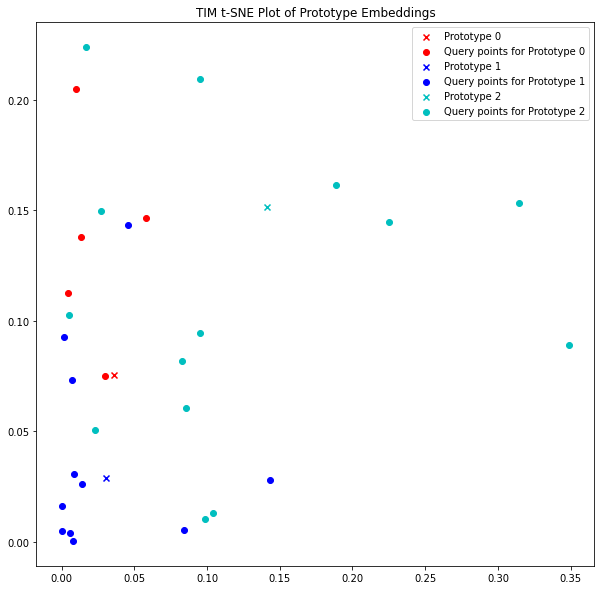

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


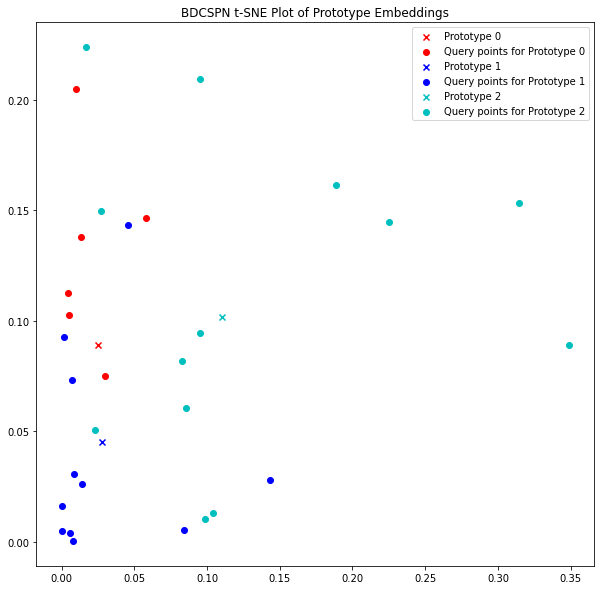

Average TIM accuracy : 67.57 %
Average BDCSPN accuracy : 61.77 %
{0, 2, 5, 6, 7, 8, 10}
{9, 3, 4, 1}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0


Training: 100%|██████████| 59/59 [01:15<00:00,  1.28s/it, loss=2.93]


Epoch 1


Training: 100%|██████████| 59/59 [01:20<00:00,  1.37s/it, loss=1.94]


Epoch 2


Training: 100%|██████████| 59/59 [01:17<00:00,  1.32s/it, loss=1.62]


Epoch 3


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=1.28]


Epoch 4


Training: 100%|██████████| 59/59 [01:18<00:00,  1.34s/it, loss=1.16]


Epoch 5


Training: 100%|██████████| 59/59 [01:17<00:00,  1.32s/it, loss=0.977]


Epoch 6


Training: 100%|██████████| 59/59 [01:19<00:00,  1.35s/it, loss=0.885]


Epoch 7


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.778]


Epoch 8


Training: 100%|██████████| 59/59 [01:19<00:00,  1.35s/it, loss=0.698]


Epoch 9


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.627]


Epoch 10


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.589]


Epoch 11


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.555]


Epoch 12


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.516]


Epoch 13


Training: 100%|██████████| 59/59 [01:16<00:00,  1.30s/it, loss=0.503]


Epoch 14


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.48]


Epoch 15


Training: 100%|██████████| 59/59 [01:17<00:00,  1.32s/it, loss=0.468]


Epoch 16


Training: 100%|██████████| 59/59 [01:21<00:00,  1.37s/it, loss=0.43]


Epoch 17


Training: 100%|██████████| 59/59 [01:17<00:00,  1.32s/it, loss=0.409]


Epoch 18


Training: 100%|██████████| 59/59 [01:19<00:00,  1.34s/it, loss=0.386]


Epoch 19


Training: 100%|██████████| 59/59 [01:16<00:00,  1.30s/it, loss=0.401]


Epoch 20


Training: 100%|██████████| 59/59 [01:17<00:00,  1.32s/it, loss=0.382]


Epoch 21


Training: 100%|██████████| 59/59 [01:16<00:00,  1.30s/it, loss=0.385]


Epoch 22


Training: 100%|██████████| 59/59 [01:16<00:00,  1.30s/it, loss=0.353]


Epoch 23


Training: 100%|██████████| 59/59 [01:18<00:00,  1.32s/it, loss=0.343]


Epoch 24


Training: 100%|██████████| 59/59 [01:17<00:00,  1.32s/it, loss=0.346]


Epoch 25


Training: 100%|██████████| 59/59 [01:19<00:00,  1.35s/it, loss=0.304]


Epoch 26


Training: 100%|██████████| 59/59 [01:17<00:00,  1.31s/it, loss=0.316]


Epoch 27


Training: 100%|██████████| 59/59 [01:17<00:00,  1.31s/it, loss=0.328]


Epoch 28


Training: 100%|██████████| 59/59 [01:16<00:00,  1.30s/it, loss=0.322]


Epoch 29


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.268]


Epoch 30


Training: 100%|██████████| 59/59 [01:16<00:00,  1.30s/it, loss=0.275]


Epoch 31


Training: 100%|██████████| 59/59 [01:16<00:00,  1.30s/it, loss=0.293]


Epoch 32


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.272]


Epoch 33


Training: 100%|██████████| 59/59 [01:17<00:00,  1.31s/it, loss=0.294]


Epoch 34


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.263]


Epoch 35


Training: 100%|██████████| 59/59 [01:16<00:00,  1.30s/it, loss=0.229]


Epoch 36


Training: 100%|██████████| 59/59 [01:17<00:00,  1.32s/it, loss=0.225]


Epoch 37


Training: 100%|██████████| 59/59 [01:16<00:00,  1.29s/it, loss=0.229]


Epoch 38


Training: 100%|██████████| 59/59 [01:17<00:00,  1.31s/it, loss=0.233]


Epoch 39


Training: 100%|██████████| 59/59 [01:18<00:00,  1.32s/it, loss=0.212]


Epoch 40


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.218]


Epoch 41


Training: 100%|██████████| 59/59 [01:17<00:00,  1.31s/it, loss=0.236]


Epoch 42


Training: 100%|██████████| 59/59 [01:18<00:00,  1.32s/it, loss=0.198]


Epoch 43


Training: 100%|██████████| 59/59 [01:20<00:00,  1.36s/it, loss=0.21]


Epoch 44


Training: 100%|██████████| 59/59 [01:17<00:00,  1.31s/it, loss=0.197]


Epoch 45


Training: 100%|██████████| 59/59 [01:19<00:00,  1.34s/it, loss=0.17]


Epoch 46


Training: 100%|██████████| 59/59 [01:17<00:00,  1.32s/it, loss=0.198]


Epoch 47


Training: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it, loss=0.179]


Epoch 48


Training: 100%|██████████| 59/59 [01:20<00:00,  1.37s/it, loss=0.153]


Epoch 49


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


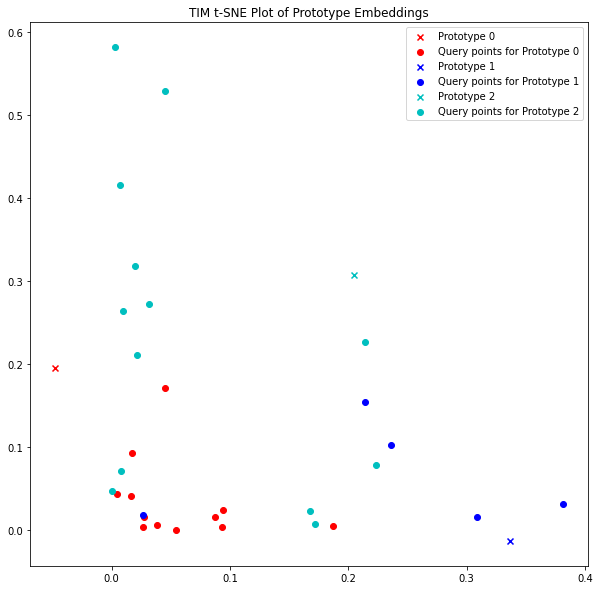

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


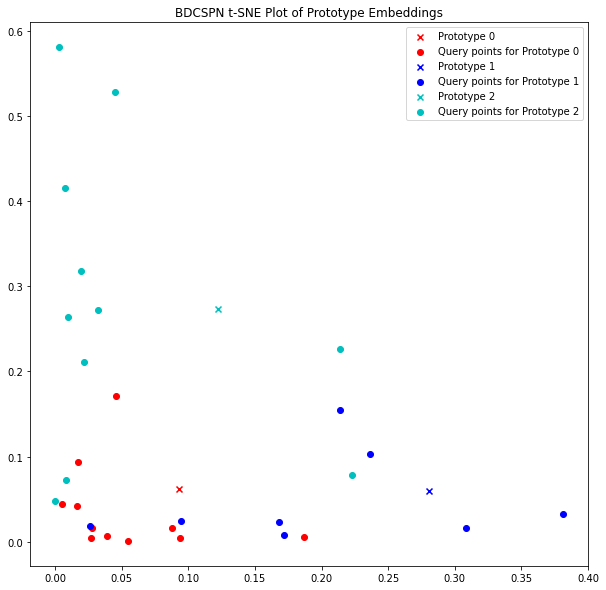

Average TIM accuracy : 55.47 %
Average BDCSPN accuracy : 52.33 %
{0, 2, 3, 4, 5, 6, 9}
{8, 1, 10, 7}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0


Training: 100%|██████████| 74/74 [01:31<00:00,  1.24s/it, loss=2.78]


Epoch 1


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=1.73]


Epoch 2


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=1.36]


Epoch 3


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=1.14]


Epoch 4


Training: 100%|██████████| 74/74 [01:35<00:00,  1.30s/it, loss=0.965]


Epoch 5


Training: 100%|██████████| 74/74 [01:35<00:00,  1.29s/it, loss=0.904]


Epoch 6


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=0.766]


Epoch 7


Training: 100%|██████████| 74/74 [01:35<00:00,  1.29s/it, loss=0.71]


Epoch 8


Training: 100%|██████████| 74/74 [01:35<00:00,  1.29s/it, loss=0.681]


Epoch 9


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.619]


Epoch 10


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.602]


Epoch 11


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.557]


Epoch 12


Training: 100%|██████████| 74/74 [01:35<00:00,  1.29s/it, loss=0.543]


Epoch 13


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.501]


Epoch 14


Training: 100%|██████████| 74/74 [01:35<00:00,  1.29s/it, loss=0.517]


Epoch 15


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.481]


Epoch 16


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.451]


Epoch 17


Training: 100%|██████████| 74/74 [01:34<00:00,  1.27s/it, loss=0.467]


Epoch 18


Training: 100%|██████████| 74/74 [01:35<00:00,  1.29s/it, loss=0.458]


Epoch 19


Training: 100%|██████████| 74/74 [01:35<00:00,  1.28s/it, loss=0.41]


Epoch 20


Training: 100%|██████████| 74/74 [01:35<00:00,  1.29s/it, loss=0.389]


Epoch 21


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.412]


Epoch 22


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.38]


Epoch 23


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.366]


Epoch 24


Training: 100%|██████████| 74/74 [01:35<00:00,  1.30s/it, loss=0.371]


Epoch 25


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.339]


Epoch 26


Training: 100%|██████████| 74/74 [01:39<00:00,  1.35s/it, loss=0.349]


Epoch 27


Training: 100%|██████████| 74/74 [01:39<00:00,  1.34s/it, loss=0.367]


Epoch 28


Training: 100%|██████████| 74/74 [01:39<00:00,  1.34s/it, loss=0.331]


Epoch 29


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.348]


Epoch 30


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.31]


Epoch 31


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.308]


Epoch 32


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=0.285]


Epoch 33


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.317]


Epoch 34


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.288]


Epoch 35


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.271]


Epoch 36


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.277]


Epoch 37


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.252]


Epoch 38


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=0.279]


Epoch 39


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.231]


Epoch 40


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.24]


Epoch 41


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.222]


Epoch 42


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.26]


Epoch 43


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.204]


Epoch 44


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.216]


Epoch 45


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.211]


Epoch 46


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.197]


Epoch 47


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.205]


Epoch 48


Training: 100%|██████████| 74/74 [01:39<00:00,  1.34s/it, loss=0.193]


Epoch 49


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


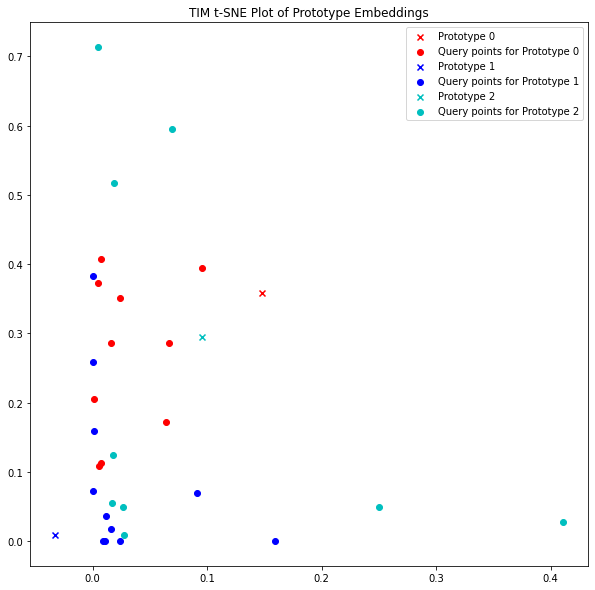

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


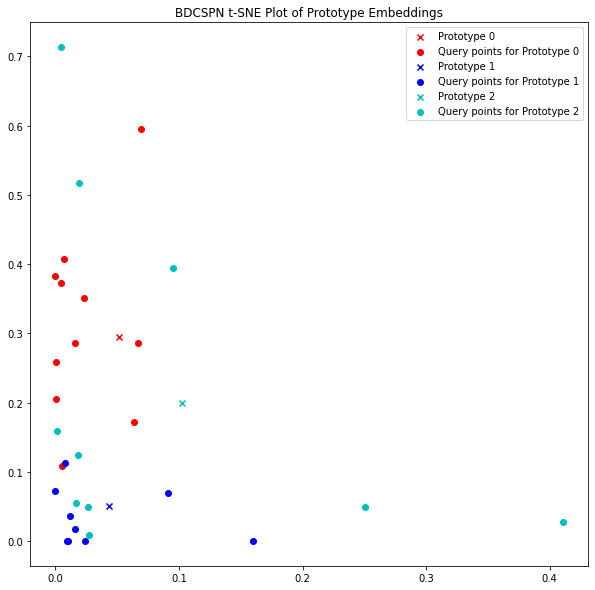

Average TIM accuracy : 79.97 %
Average BDCSPN accuracy : 73.73 %
{0, 2, 3, 7, 8, 9, 10}
{1, 4, 5, 6}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0


Training: 100%|██████████| 69/69 [01:33<00:00,  1.35s/it, loss=3.07]


Epoch 1


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=1.8]


Epoch 2


Training: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, loss=1.55]


Epoch 3


Training: 100%|██████████| 69/69 [01:34<00:00,  1.37s/it, loss=1.38]


Epoch 4


Training: 100%|██████████| 69/69 [01:30<00:00,  1.32s/it, loss=1.21]


Epoch 5


Training: 100%|██████████| 69/69 [01:34<00:00,  1.37s/it, loss=0.961]


Epoch 6


Training: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, loss=0.806]


Epoch 7


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=0.767]


Epoch 8


Training: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, loss=0.703]


Epoch 9


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=0.608]


Epoch 10


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=0.6]


Epoch 11


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=0.549]


Epoch 12


Training: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, loss=0.525]


Epoch 13


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=0.502]


Epoch 14


Training: 100%|██████████| 69/69 [01:33<00:00,  1.35s/it, loss=0.465]


Epoch 15


Training: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, loss=0.438]


Epoch 16


Training: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, loss=0.424]


Epoch 17


Training: 100%|██████████| 69/69 [01:33<00:00,  1.35s/it, loss=0.425]


Epoch 18


Training: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, loss=0.411]


Epoch 19


Training: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, loss=0.381]


Epoch 20


Training: 100%|██████████| 69/69 [01:32<00:00,  1.35s/it, loss=0.378]


Epoch 21


Training: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, loss=0.374]


Epoch 22


Training: 100%|██████████| 69/69 [01:30<00:00,  1.32s/it, loss=0.354]


Epoch 23


Training: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, loss=0.335]


Epoch 24


Training: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, loss=0.341]


Epoch 25


Training: 100%|██████████| 69/69 [01:32<00:00,  1.34s/it, loss=0.33]


Epoch 26


Training: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, loss=0.328]


Epoch 27


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=0.305]


Epoch 28


Training: 100%|██████████| 69/69 [01:29<00:00,  1.30s/it, loss=0.315]


Epoch 29


Training: 100%|██████████| 69/69 [01:33<00:00,  1.36s/it, loss=0.279]


Epoch 30


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=0.283]


Epoch 31


Training: 100%|██████████| 69/69 [01:34<00:00,  1.36s/it, loss=0.299]


Epoch 32


Training: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, loss=0.268]


Epoch 33


Training: 100%|██████████| 69/69 [01:30<00:00,  1.32s/it, loss=0.268]


Epoch 34


Training: 100%|██████████| 69/69 [01:32<00:00,  1.34s/it, loss=0.259]


Epoch 35


Training: 100%|██████████| 69/69 [01:30<00:00,  1.32s/it, loss=0.251]


Epoch 36


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=0.221]


Epoch 37


Training: 100%|██████████| 69/69 [01:34<00:00,  1.36s/it, loss=0.242]


Epoch 38


Training: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, loss=0.236]


Epoch 39


Training: 100%|██████████| 69/69 [01:32<00:00,  1.34s/it, loss=0.221]


Epoch 40


Training: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, loss=0.211]


Epoch 41


Training: 100%|██████████| 69/69 [01:33<00:00,  1.36s/it, loss=0.203]


Epoch 42


Training: 100%|██████████| 69/69 [01:32<00:00,  1.34s/it, loss=0.223]


Epoch 43


Training: 100%|██████████| 69/69 [01:32<00:00,  1.34s/it, loss=0.165]


Epoch 44


Training: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it, loss=0.173]


Epoch 45


Training: 100%|██████████| 69/69 [01:31<00:00,  1.33s/it, loss=0.179]


Epoch 46


Training: 100%|██████████| 69/69 [01:32<00:00,  1.35s/it, loss=0.184]


Epoch 47


Training: 100%|██████████| 69/69 [01:30<00:00,  1.32s/it, loss=0.157]


Epoch 48


Training: 100%|██████████| 69/69 [01:31<00:00,  1.32s/it, loss=0.16]


Epoch 49


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


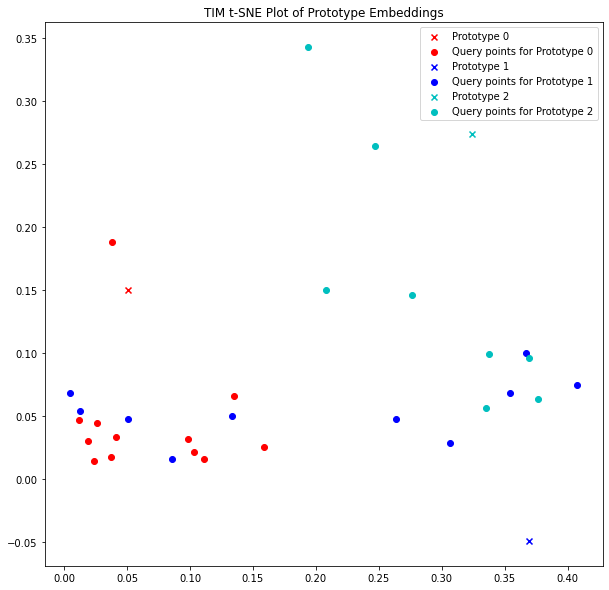

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


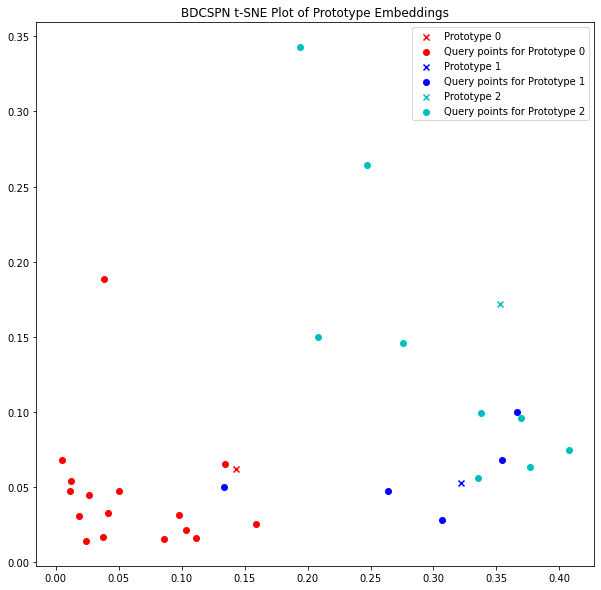

Average TIM accuracy : 72.27 %
Average BDCSPN accuracy : 69.47 %
{0, 1, 2, 3, 6, 8, 9}
{10, 4, 5, 7}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0


Training: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it, loss=3.42]


Epoch 1


Training: 100%|██████████| 75/75 [01:40<00:00,  1.34s/it, loss=1.8]


Epoch 2


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=1.46]


Epoch 3


Training: 100%|██████████| 75/75 [01:39<00:00,  1.32s/it, loss=1.17]


Epoch 4


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.989]


Epoch 5


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.878]


Epoch 6


Training: 100%|██████████| 75/75 [01:37<00:00,  1.31s/it, loss=0.805]


Epoch 7


Training: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it, loss=0.72]


Epoch 8


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.662]


Epoch 9


Training: 100%|██████████| 75/75 [01:36<00:00,  1.29s/it, loss=0.586]


Epoch 10


Training: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it, loss=0.548]


Epoch 11


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.555]


Epoch 12


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.478]


Epoch 13


Training: 100%|██████████| 75/75 [01:36<00:00,  1.29s/it, loss=0.497]


Epoch 14


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.481]


Epoch 15


Training: 100%|██████████| 75/75 [01:40<00:00,  1.34s/it, loss=0.462]


Epoch 16


Training: 100%|██████████| 75/75 [01:40<00:00,  1.34s/it, loss=0.413]


Epoch 17


Training: 100%|██████████| 75/75 [01:36<00:00,  1.29s/it, loss=0.416]


Epoch 18


Training: 100%|██████████| 75/75 [01:40<00:00,  1.34s/it, loss=0.364]


Epoch 19


Training: 100%|██████████| 75/75 [01:38<00:00,  1.32s/it, loss=0.375]


Epoch 20


Training: 100%|██████████| 75/75 [01:38<00:00,  1.32s/it, loss=0.335]


Epoch 21


Training: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it, loss=0.348]


Epoch 22


Training: 100%|██████████| 75/75 [01:39<00:00,  1.32s/it, loss=0.316]


Epoch 23


Training: 100%|██████████| 75/75 [01:39<00:00,  1.33s/it, loss=0.317]


Epoch 24


Training: 100%|██████████| 75/75 [01:39<00:00,  1.33s/it, loss=0.321]


Epoch 25


Training: 100%|██████████| 75/75 [01:38<00:00,  1.32s/it, loss=0.311]


Epoch 26


Training: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it, loss=0.282]


Epoch 27


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.288]


Epoch 28


Training: 100%|██████████| 75/75 [01:38<00:00,  1.32s/it, loss=0.27]


Epoch 29


Training: 100%|██████████| 75/75 [01:37<00:00,  1.29s/it, loss=0.249]


Epoch 30


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.262]


Epoch 31


Training: 100%|██████████| 75/75 [01:40<00:00,  1.34s/it, loss=0.257]


Epoch 32


Training: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it, loss=0.242]


Epoch 33


Training: 100%|██████████| 75/75 [01:37<00:00,  1.29s/it, loss=0.237]


Epoch 34


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.219]


Epoch 35


Training: 100%|██████████| 75/75 [01:38<00:00,  1.32s/it, loss=0.221]


Epoch 36


Training: 100%|██████████| 75/75 [01:38<00:00,  1.32s/it, loss=0.194]


Epoch 37


Training: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it, loss=0.221]


Epoch 38


Training: 100%|██████████| 75/75 [01:36<00:00,  1.28s/it, loss=0.19]


Epoch 39


Training: 100%|██████████| 75/75 [01:36<00:00,  1.29s/it, loss=0.19]


Epoch 40


Training: 100%|██████████| 75/75 [01:39<00:00,  1.33s/it, loss=0.194]


Epoch 41


Training: 100%|██████████| 75/75 [01:36<00:00,  1.29s/it, loss=0.205]


Epoch 42


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.185]


Epoch 43


Training: 100%|██████████| 75/75 [01:38<00:00,  1.32s/it, loss=0.168]


Epoch 44


Training: 100%|██████████| 75/75 [01:38<00:00,  1.32s/it, loss=0.182]


Epoch 45


Training: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it, loss=0.166]


Epoch 46


Training: 100%|██████████| 75/75 [01:36<00:00,  1.29s/it, loss=0.162]


Epoch 47


Training: 100%|██████████| 75/75 [01:38<00:00,  1.31s/it, loss=0.16]


Epoch 48


Training: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it, loss=0.187]


Epoch 49


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


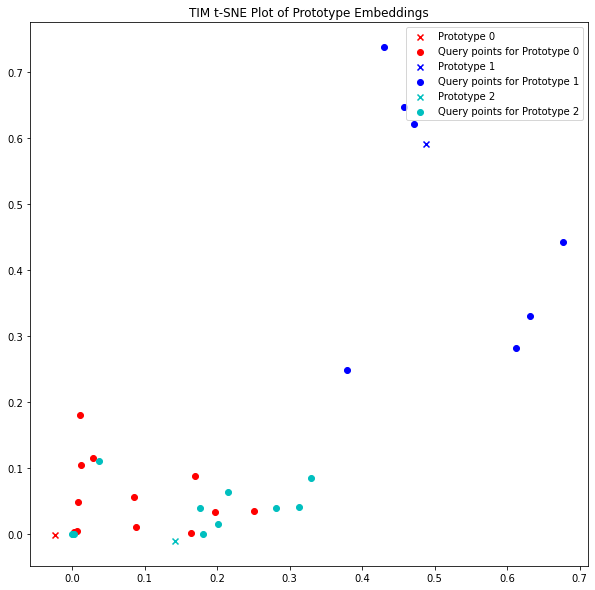

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


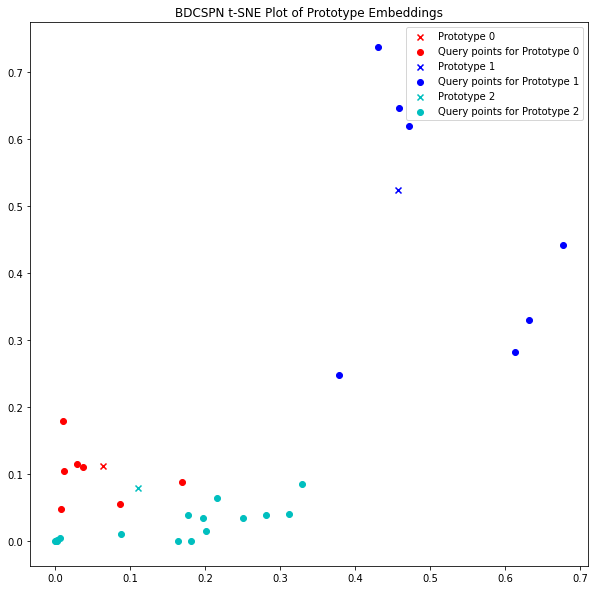

Average TIM accuracy : 72.60 %
Average BDCSPN accuracy : 64.73 %
{2, 5, 6, 7, 8, 9, 10}
{0, 1, 3, 4}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0


Training: 100%|██████████| 60/60 [01:22<00:00,  1.37s/it, loss=2.75]


Epoch 1


Training: 100%|██████████| 60/60 [01:20<00:00,  1.33s/it, loss=1.89]


Epoch 2


Training: 100%|██████████| 60/60 [01:21<00:00,  1.36s/it, loss=1.84]


Epoch 3


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=1.8]


Epoch 4


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=1.53]


Epoch 5


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=1.26]


Epoch 6


Training: 100%|██████████| 60/60 [01:19<00:00,  1.32s/it, loss=1.12]


Epoch 7


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=0.934]


Epoch 8


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.793]


Epoch 9


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.676]


Epoch 10


Training: 100%|██████████| 60/60 [01:19<00:00,  1.32s/it, loss=0.6]


Epoch 11


Training: 100%|██████████| 60/60 [01:21<00:00,  1.35s/it, loss=0.564]


Epoch 12


Training: 100%|██████████| 60/60 [01:20<00:00,  1.35s/it, loss=0.528]


Epoch 13


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=0.515]


Epoch 14


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.489]


Epoch 15


Training: 100%|██████████| 60/60 [01:22<00:00,  1.38s/it, loss=0.44]


Epoch 16


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=0.392]


Epoch 17


Training: 100%|██████████| 60/60 [01:19<00:00,  1.32s/it, loss=0.409]


Epoch 18


Training: 100%|██████████| 60/60 [01:20<00:00,  1.35s/it, loss=0.372]


Epoch 19


Training: 100%|██████████| 60/60 [01:19<00:00,  1.32s/it, loss=0.326]


Epoch 20


Training: 100%|██████████| 60/60 [01:20<00:00,  1.33s/it, loss=0.319]


Epoch 21


Training: 100%|██████████| 60/60 [01:19<00:00,  1.32s/it, loss=0.326]


Epoch 22


Training: 100%|██████████| 60/60 [01:23<00:00,  1.39s/it, loss=0.294]


Epoch 23


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=0.295]


Epoch 24


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=0.273]


Epoch 25


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.257]


Epoch 26


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=0.271]


Epoch 27


Training: 100%|██████████| 60/60 [01:21<00:00,  1.35s/it, loss=0.244]


Epoch 28


Training: 100%|██████████| 60/60 [01:20<00:00,  1.33s/it, loss=0.23]


Epoch 29


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.241]


Epoch 30


Training: 100%|██████████| 60/60 [01:19<00:00,  1.32s/it, loss=0.224]


Epoch 31


Training: 100%|██████████| 60/60 [01:18<00:00,  1.31s/it, loss=0.231]


Epoch 32


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.206]


Epoch 33


Training: 100%|██████████| 60/60 [01:18<00:00,  1.31s/it, loss=0.215]


Epoch 34


Training: 100%|██████████| 60/60 [01:18<00:00,  1.31s/it, loss=0.184]


Epoch 35


Training: 100%|██████████| 60/60 [01:19<00:00,  1.32s/it, loss=0.178]


Epoch 36


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.178]


Epoch 37


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.221]


Epoch 38


Training: 100%|██████████| 60/60 [01:19<00:00,  1.32s/it, loss=0.165]


Epoch 39


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.171]


Epoch 40


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.166]


Epoch 41


Training: 100%|██████████| 60/60 [01:18<00:00,  1.31s/it, loss=0.175]


Epoch 42


Training: 100%|██████████| 60/60 [01:21<00:00,  1.36s/it, loss=0.157]


Epoch 43


Training: 100%|██████████| 60/60 [01:18<00:00,  1.31s/it, loss=0.159]


Epoch 44


Training: 100%|██████████| 60/60 [01:21<00:00,  1.36s/it, loss=0.157]


Epoch 45


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=0.15]


Epoch 46


Training: 100%|██████████| 60/60 [01:19<00:00,  1.33s/it, loss=0.147]


Epoch 47


Training: 100%|██████████| 60/60 [01:20<00:00,  1.34s/it, loss=0.118]


Epoch 48


Training: 100%|██████████| 60/60 [01:18<00:00,  1.31s/it, loss=0.149]


Epoch 49


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


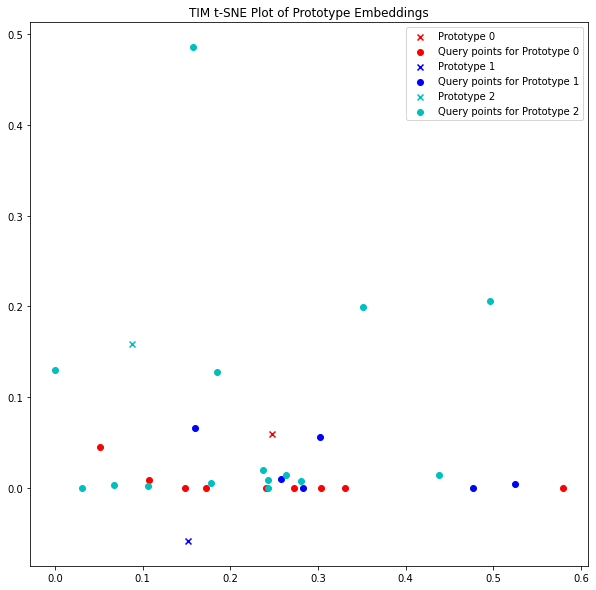

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


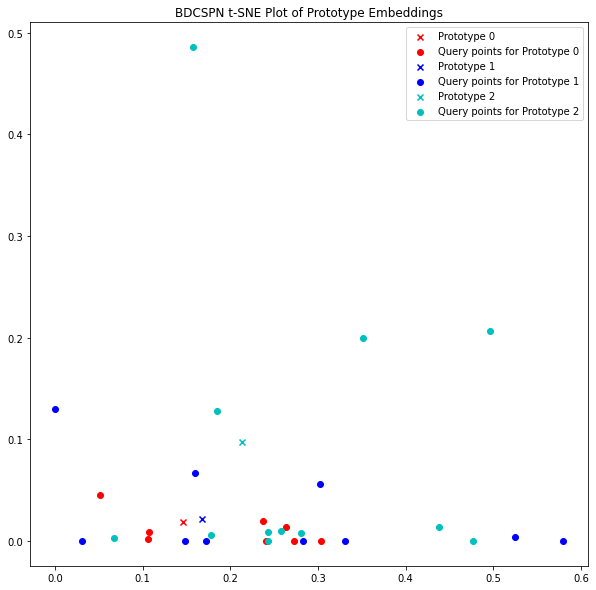

Average TIM accuracy : 50.50 %
Average BDCSPN accuracy : 46.03 %
{2, 4, 5, 6, 7, 8, 9}
{0, 1, 10, 3}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=2.87]


Epoch 1


Training: 100%|██████████| 68/68 [01:31<00:00,  1.34s/it, loss=1.92]


Epoch 2


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=1.64]


Epoch 3


Training: 100%|██████████| 68/68 [01:30<00:00,  1.34s/it, loss=1.19]


Epoch 4


Training: 100%|██████████| 68/68 [01:31<00:00,  1.35s/it, loss=0.941]


Epoch 5


Training: 100%|██████████| 68/68 [01:32<00:00,  1.37s/it, loss=0.746]


Epoch 6


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=0.65]


Epoch 7


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.568]


Epoch 8


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.538]


Epoch 9


Training: 100%|██████████| 68/68 [01:32<00:00,  1.37s/it, loss=0.494]


Epoch 10


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.451]


Epoch 11


Training: 100%|██████████| 68/68 [01:31<00:00,  1.34s/it, loss=0.403]


Epoch 12


Training: 100%|██████████| 68/68 [01:31<00:00,  1.35s/it, loss=0.369]


Epoch 13


Training: 100%|██████████| 68/68 [01:32<00:00,  1.36s/it, loss=0.382]


Epoch 14


Training: 100%|██████████| 68/68 [01:31<00:00,  1.34s/it, loss=0.32]


Epoch 15


Training: 100%|██████████| 68/68 [01:33<00:00,  1.37s/it, loss=0.336]


Epoch 16


Training: 100%|██████████| 68/68 [01:33<00:00,  1.37s/it, loss=0.321]


Epoch 17


Training: 100%|██████████| 68/68 [01:31<00:00,  1.35s/it, loss=0.308]


Epoch 18


Training: 100%|██████████| 68/68 [01:32<00:00,  1.35s/it, loss=0.282]


Epoch 19


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.292]


Epoch 20


Training: 100%|██████████| 68/68 [01:31<00:00,  1.35s/it, loss=0.261]


Epoch 21


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=0.239]


Epoch 22


Training: 100%|██████████| 68/68 [01:32<00:00,  1.37s/it, loss=0.236]


Epoch 23


Training: 100%|██████████| 68/68 [01:32<00:00,  1.37s/it, loss=0.235]


Epoch 24


Training: 100%|██████████| 68/68 [01:33<00:00,  1.37s/it, loss=0.221]


Epoch 25


Training: 100%|██████████| 68/68 [01:33<00:00,  1.38s/it, loss=0.207]


Epoch 26


Training: 100%|██████████| 68/68 [01:30<00:00,  1.34s/it, loss=0.202]


Epoch 27


Training: 100%|██████████| 68/68 [01:28<00:00,  1.31s/it, loss=0.2]


Epoch 28


Training: 100%|██████████| 68/68 [01:29<00:00,  1.31s/it, loss=0.176]


Epoch 29


Training: 100%|██████████| 68/68 [01:31<00:00,  1.35s/it, loss=0.164]


Epoch 30


Training: 100%|██████████| 68/68 [01:31<00:00,  1.34s/it, loss=0.158]


Epoch 31


Training: 100%|██████████| 68/68 [01:34<00:00,  1.39s/it, loss=0.186]


Epoch 32


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.159]


Epoch 33


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.145]


Epoch 34


Training: 100%|██████████| 68/68 [01:32<00:00,  1.36s/it, loss=0.158]


Epoch 35


Training: 100%|██████████| 68/68 [01:31<00:00,  1.35s/it, loss=0.146]


Epoch 36


Training: 100%|██████████| 68/68 [01:28<00:00,  1.31s/it, loss=0.136]


Epoch 37


Training: 100%|██████████| 68/68 [01:28<00:00,  1.30s/it, loss=0.141]


Epoch 38


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.164]


Epoch 39


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=0.264]


Epoch 40


Training: 100%|██████████| 68/68 [01:30<00:00,  1.33s/it, loss=0.143]


Epoch 41


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=0.143]


Epoch 42


Training: 100%|██████████| 68/68 [01:29<00:00,  1.31s/it, loss=0.116]


Epoch 43


Training: 100%|██████████| 68/68 [01:31<00:00,  1.34s/it, loss=0.117]


Epoch 44


Training: 100%|██████████| 68/68 [01:32<00:00,  1.36s/it, loss=0.098]


Epoch 45


Training: 100%|██████████| 68/68 [01:34<00:00,  1.40s/it, loss=0.0895]


Epoch 46


Training: 100%|██████████| 68/68 [01:32<00:00,  1.36s/it, loss=0.0995]


Epoch 47


Training: 100%|██████████| 68/68 [01:31<00:00,  1.35s/it, loss=0.104]


Epoch 48


Training: 100%|██████████| 68/68 [01:29<00:00,  1.32s/it, loss=0.0845]


Epoch 49


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


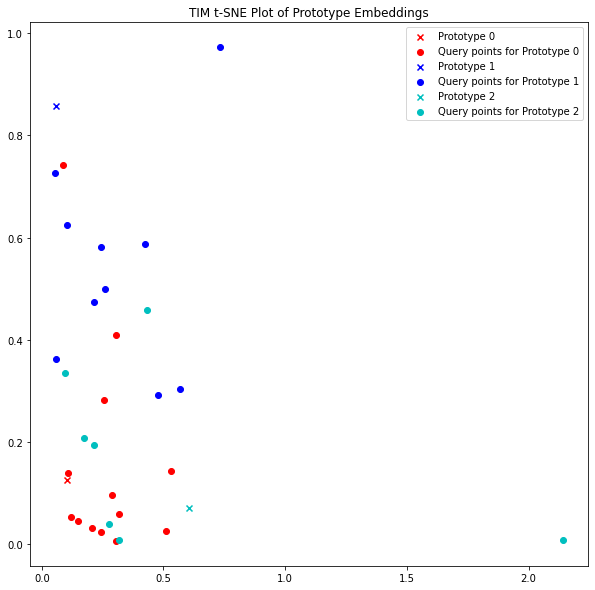

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


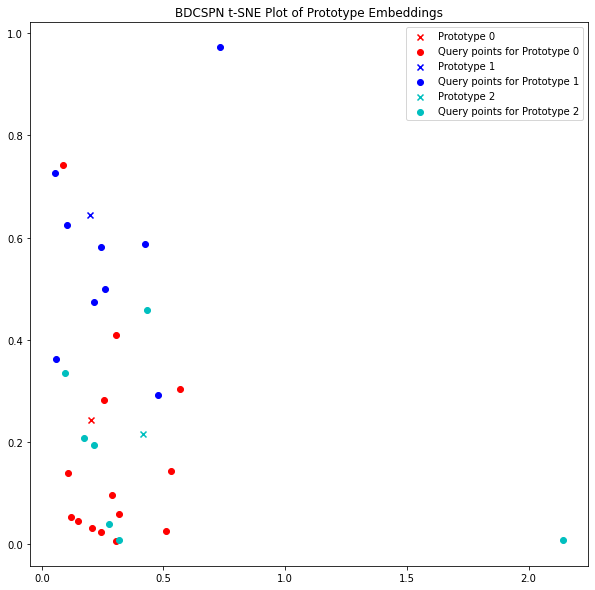

Average TIM accuracy : 60.40 %
Average BDCSPN accuracy : 57.80 %
{0, 1, 2, 3, 4, 6, 8}
{9, 10, 5, 7}


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0


Training: 100%|██████████| 74/74 [01:39<00:00,  1.35s/it, loss=2.77]


Epoch 1


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=1.86]


Epoch 2


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=1.73]


Epoch 3


Training: 100%|██████████| 74/74 [01:39<00:00,  1.34s/it, loss=1.49]


Epoch 4


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=1.29]


Epoch 5


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=1.16]


Epoch 6


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=1.04]


Epoch 7


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=0.987]


Epoch 8


Training: 100%|██████████| 74/74 [01:39<00:00,  1.34s/it, loss=0.877]


Epoch 9


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.793]


Epoch 10


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.759]


Epoch 11


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=0.695]


Epoch 12


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.656]


Epoch 13


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.629]


Epoch 14


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=0.603]


Epoch 15


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=0.568]


Epoch 16


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.532]


Epoch 17


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.493]


Epoch 18


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.483]


Epoch 19


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.446]


Epoch 20


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.467]


Epoch 21


Training: 100%|██████████| 74/74 [01:39<00:00,  1.35s/it, loss=0.42]


Epoch 22


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.42]


Epoch 23


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.387]


Epoch 24


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.387]


Epoch 25


Training: 100%|██████████| 74/74 [01:39<00:00,  1.35s/it, loss=0.385]


Epoch 26


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.365]


Epoch 27


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.433]


Epoch 28


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.337]


Epoch 29


Training: 100%|██████████| 74/74 [01:40<00:00,  1.36s/it, loss=0.321]


Epoch 30


Training: 100%|██████████| 74/74 [01:38<00:00,  1.34s/it, loss=0.307]


Epoch 31


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=0.294]


Epoch 32


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.311]


Epoch 33


Training: 100%|██████████| 74/74 [01:42<00:00,  1.39s/it, loss=0.273]


Epoch 34


Training: 100%|██████████| 74/74 [01:39<00:00,  1.35s/it, loss=0.281]


Epoch 35


Training: 100%|██████████| 74/74 [01:39<00:00,  1.34s/it, loss=0.293]


Epoch 36


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.248]


Epoch 37


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.256]


Epoch 38


Training: 100%|██████████| 74/74 [01:40<00:00,  1.35s/it, loss=0.247]


Epoch 39


Training: 100%|██████████| 74/74 [01:38<00:00,  1.34s/it, loss=0.228]


Epoch 40


Training: 100%|██████████| 74/74 [01:39<00:00,  1.35s/it, loss=0.262]


Epoch 41


Training: 100%|██████████| 74/74 [01:38<00:00,  1.32s/it, loss=0.223]


Epoch 42


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.205]


Epoch 43


Training: 100%|██████████| 74/74 [01:37<00:00,  1.32s/it, loss=0.197]


Epoch 44


Training: 100%|██████████| 74/74 [01:38<00:00,  1.32s/it, loss=0.224]


Epoch 45


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.184]


Epoch 46


Training: 100%|██████████| 74/74 [01:36<00:00,  1.30s/it, loss=0.19]


Epoch 47


Training: 100%|██████████| 74/74 [01:37<00:00,  1.31s/it, loss=0.15]


Epoch 48


Training: 100%|██████████| 74/74 [01:38<00:00,  1.33s/it, loss=0.189]


Epoch 49


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


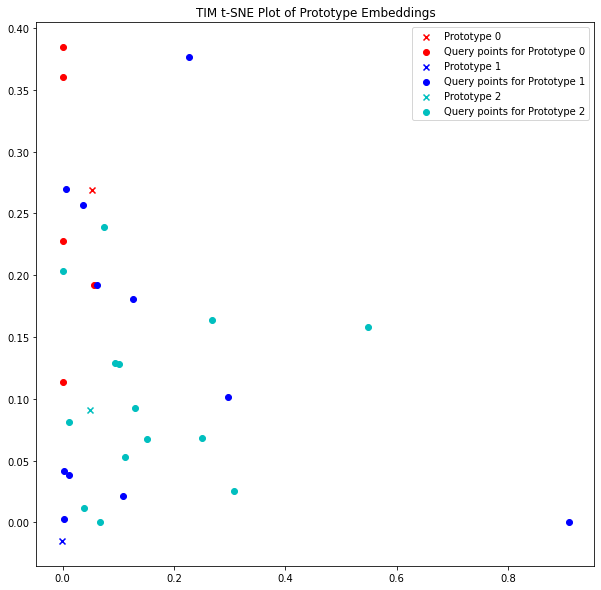

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


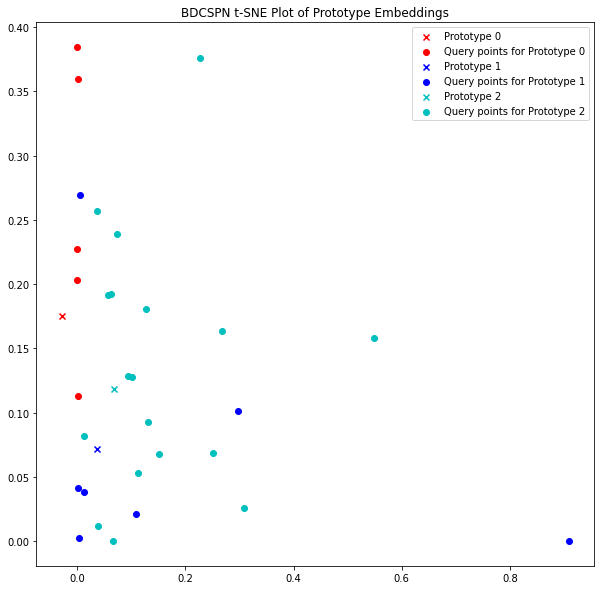

Average TIM accuracy : 73.07 %
Average BDCSPN accuracy : 67.90 %


In [11]:

# Define the number of folds
num_folds = 8

# Get the list of all class labels in the dataset
all_classes = set([label for _, label in dataset])

# print(all_classes)

for _ in range(num_folds):
    # Split the trainval set into train and validation sets based on class labels
#     train_classes = set([label for i, (img, label) in enumerate(dataset) if i in trainval_idx])
    trainval_classes = all_classes.copy()
#     val_classes = set()
    test_classes = set()
#     while len(val_classes) < 2:
#         class_label = np.random.choice(list(trainval_classes))
#         trainval_classes.remove(class_label)
#         val_classes.add(class_label)
    while len(test_classes) < 4:
        class_label = np.random.choice(list(trainval_classes))
        trainval_classes.remove(class_label)
        test_classes.add(class_label)
    train_idx = [i for i, (img, label) in enumerate(dataset) if dataset[i][1] in trainval_classes]
#     val_idx = [i for i in trainval_idx if dataset[i][1] in val_classes]
    test_idx = [i for i, (img, label) in enumerate(dataset) if dataset[i][1] in test_classes]
    
#     torch.cuda.empty_cache()
    print(trainval_classes)
    print(test_classes)
    
    train_set = Subset(dataset, train_idx)
    LOSS_FUNCTION = nn.CrossEntropyLoss()
    batch_size = 128
    n_workers = 12
    n_epochs = 50
    scheduler_milestones = [150, 180]
    scheduler_gamma = 0.1
    learning_rate = 1e-01
    tb_logs_dir = Path(".")
    DEVICE = "cuda"

    model = resnet34(
        use_fc=True,
        num_classes=11,
    ).to(DEVICE)
    
    tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))
    few_shot_classifier = TIM_TSNE(model).to(DEVICE)
    few_shot_classifier2 = BDCSPN_TSNE(model).to(DEVICE)
#     few_shot_classifier3 = BDIMPN_TSNE(model).to(DEVICE)
    train_set.get_labels = lambda: [
        instance[1] for instance in train_set
    ]
  
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        num_workers=n_workers,
        pin_memory=True,
        shuffle=True,
    )
    train_optimizer = SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )
    train_scheduler = MultiStepLR(
        train_optimizer,
        milestones=scheduler_milestones,
        gamma=scheduler_gamma,
    )


    
#     val_set = Subset(dataset, val_idx)
    
#     n_way = 2
#     n_shot = 5
#     n_query = 10
#     n_validation_tasks = 200
#     val_set.get_labels = lambda: [
#         instance[1] for instance in val_set
#     ]
#     val_sampler = TaskSampler(
#         val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
#     )
#     val_loader = DataLoader(
#         val_set,
#         batch_sampler=val_sampler,
#         num_workers=n_workers,
#         pin_memory=True,
#         collate_fn=val_sampler.episodic_collate_fn,
#     )

    test_set = Subset(dataset, test_idx)
    
    n_test_tasks = 100


    n_way = 3
    n_shot = 5
    n_query = 10

    test_set.get_labels = lambda: [
        instance[1] for instance in test_set
    ]
    test_sampler = TaskSampler(
        test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
    )
    test_loader = DataLoader(
        test_set,
        batch_sampler=test_sampler,
        num_workers=n_workers,
        pin_memory=True,
        collate_fn=test_sampler.episodic_collate_fn,
    )
    
    
    
    model.requires_grad_(True)
    best_state = model.state_dict()
    best_validation_accuracy = 0.0
    validation_frequency = 10
    for epoch in range(50):
        print(f"Epoch {epoch}")
        average_loss = training_epoch(model, train_loader, train_optimizer)

#         if epoch % validation_frequency == validation_frequency - 1:

            # We use this very convenient method from EasyFSL's ResNet to specify
            # that the model shouldn't use its last fully connected layer during validation.
#             model.set_use_fc(False)
# #             print('TIM : \n')
#             validation_accuracy_tim,validation_accuracy_bdcspn = evaluate(
#                 few_shot_classifier,few_shot_classifier2, val_loader, device=DEVICE, tqdm_prefix="Validation"
#             )
          
#     #         few_shot_classifier.plot_prototypes_tsne()
#             model.set_use_fc(True)

# #             if validation_accuracy > best_validation_accuracy:
# #                 best_validation_accuracy = validation_accuracy
# #                 best_state = model.state_dict()
# #                 print("Ding ding ding! We found a new best model!")

#             tb_writer.add_scalar("Val/acc TIM", validation_accuracy_tim, epoch)
#             tb_writer.add_scalar("Val/acc BDCSPN", validation_accuracy_bdcspn, epoch)

        tb_writer.add_scalar("Train/loss", average_loss, epoch)

        # Warn the scheduler that we did an epoch
        # so it knows when to decrease the learning rate
        train_scheduler.step()

    model.set_use_fc(False)
    model.requires_grad_(False)
    accuracies = evaluate([few_shot_classifier,few_shot_classifier2], test_loader, device=DEVICE)
    few_shot_classifier.plot_prototypes_tsne()
    few_shot_classifier2.plot_prototypes_tsne()
#     few_shot_classifier3.plot_prototypes_tsne()
    print(f"Average TIM accuracy : {(100 * accuracies[0]):.2f} %")
    print(f"Average BDCSPN accuracy : {(100 * accuracies[1]):.2f} %")
#     print(f"Average BDIMPN accuracy : {(100 * accuracies[2]):.2f} %")
#     accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
#     few_shot_classifier.plot_prototypes_tsne()
#     print(f"Average accuracy : {(100 * accuracy):.2f} %")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [00:47<00:00,  2.10it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


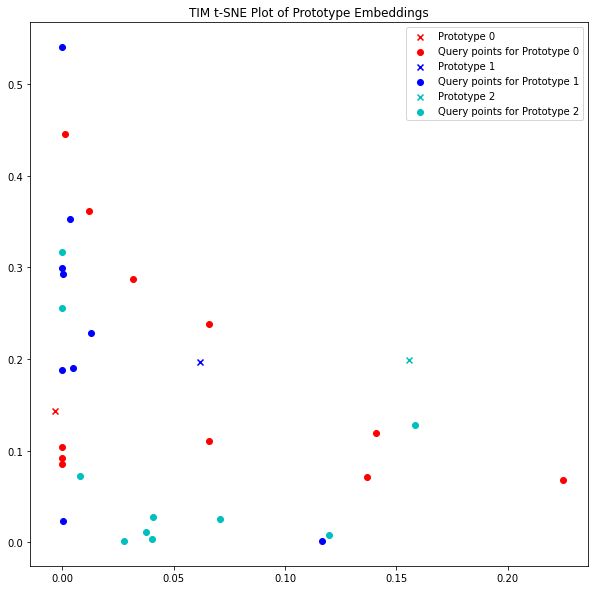

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


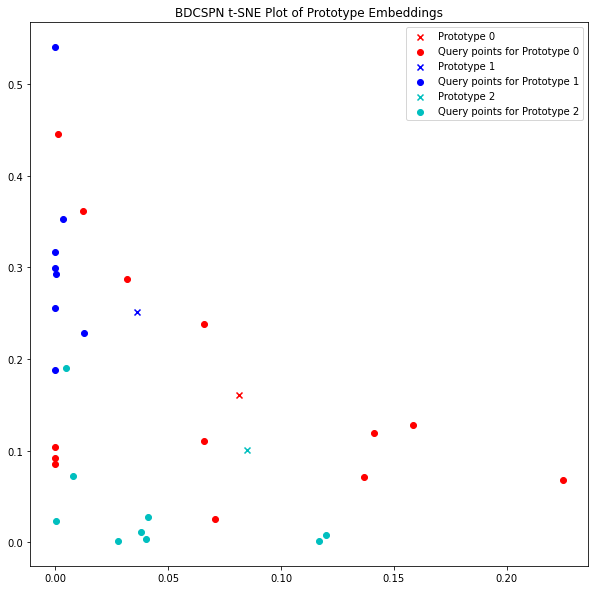

Average TIM accuracy : 72.17 %
Average BDCSPN accuracy : 66.57 %


In [12]:
model.set_use_fc(False)
model.requires_grad_(False)
accuracies = evaluate([few_shot_classifier,few_shot_classifier2], test_loader, device=DEVICE)
few_shot_classifier.plot_prototypes_tsne()
few_shot_classifier2.plot_prototypes_tsne()
# few_shot_classifier3.plot_prototypes_tsne()
print(f"Average TIM accuracy : {(100 * accuracies[0]):.2f} %")
print(f"Average BDCSPN accuracy : {(100 * accuracies[1]):.2f} %")
# print(f"Average BDIMPN accuracy : {(100 * accuracies[2]):.2f} %")

In [13]:
model.load_state_dict(best_state)

<All keys matched successfully>

In [14]:
n_test_tasks = 1000
from easyfsl.methods.utils import evaluate

n_way = 3
n_shot = 5
n_query = 10

test_set.get_labels = lambda: [
    instance[1] for instance in test_set
]
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
import tensorflow as tf

def predict_on_one_task(
    model,
    support_images,
    support_labels,
    query_images,
    query_labels,
) -> [int, int]:
    model.process_support_set(support_images, support_labels)
    return torch.max(
            model(query_images).detach().data,
            1,
        )[1]

    


def predict(
    model1,
    model2,
    data_loader,
    device: str = "cuda",
    use_tqdm: bool = True,
    tqdm_prefix: str = None,
    GRID=[5,6], SIZE=(30,25)
) -> float:

    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph
    model.eval()
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=SIZE)
    
    i=1
    with torch.no_grad():
        with tqdm(
            enumerate(data_loader),
            total=len(data_loader),
            disable=not use_tqdm,
#             desc=tqdm_prefix,
        ) as tqdm_eval:
#             print(tqdm_eval)
            for _, (
                support_images,
                support_labels,
                query_images,
                query_labels,
                _,
            ) in tqdm_eval:
                pred1 = predict_on_one_task(
                    model1,
                    support_images.to(device),
                    support_labels.to(device),
                    query_images.to(device),
                    query_labels.to(device),
                )
            
                pred2 = predict_on_one_task(
                    model2,
                    support_images.to(device),
                    support_labels.to(device),
                    query_images.to(device),
                    query_labels.to(device),
                )
#                 print(pred)
                
                id = np.random.randint(len(query_images))
                image, label = tf.expand_dims(query_images[id].T,axis=0), class_names[int(query_labels[id])]
                title = "True : {}\n TIM Pred : {}\nBDCSPN Pred : {}".format(label, class_names[int(pred1[id])], class_names[int(pred2[id])])
                plt.subplot(n_rows, n_cols, i)
                plt.imshow(image[0])
                plt.axis('off')
                plt.title(title)

                i+=1
                if i>n_images: break

In [16]:
import os

class_names = sorted(os.listdir('/kaggle/input/tomato-disease-multiple-sources/train'))
n_classes   = len(class_names)

  3%|▎         | 29/1000 [00:20<11:42,  1.38it/s]


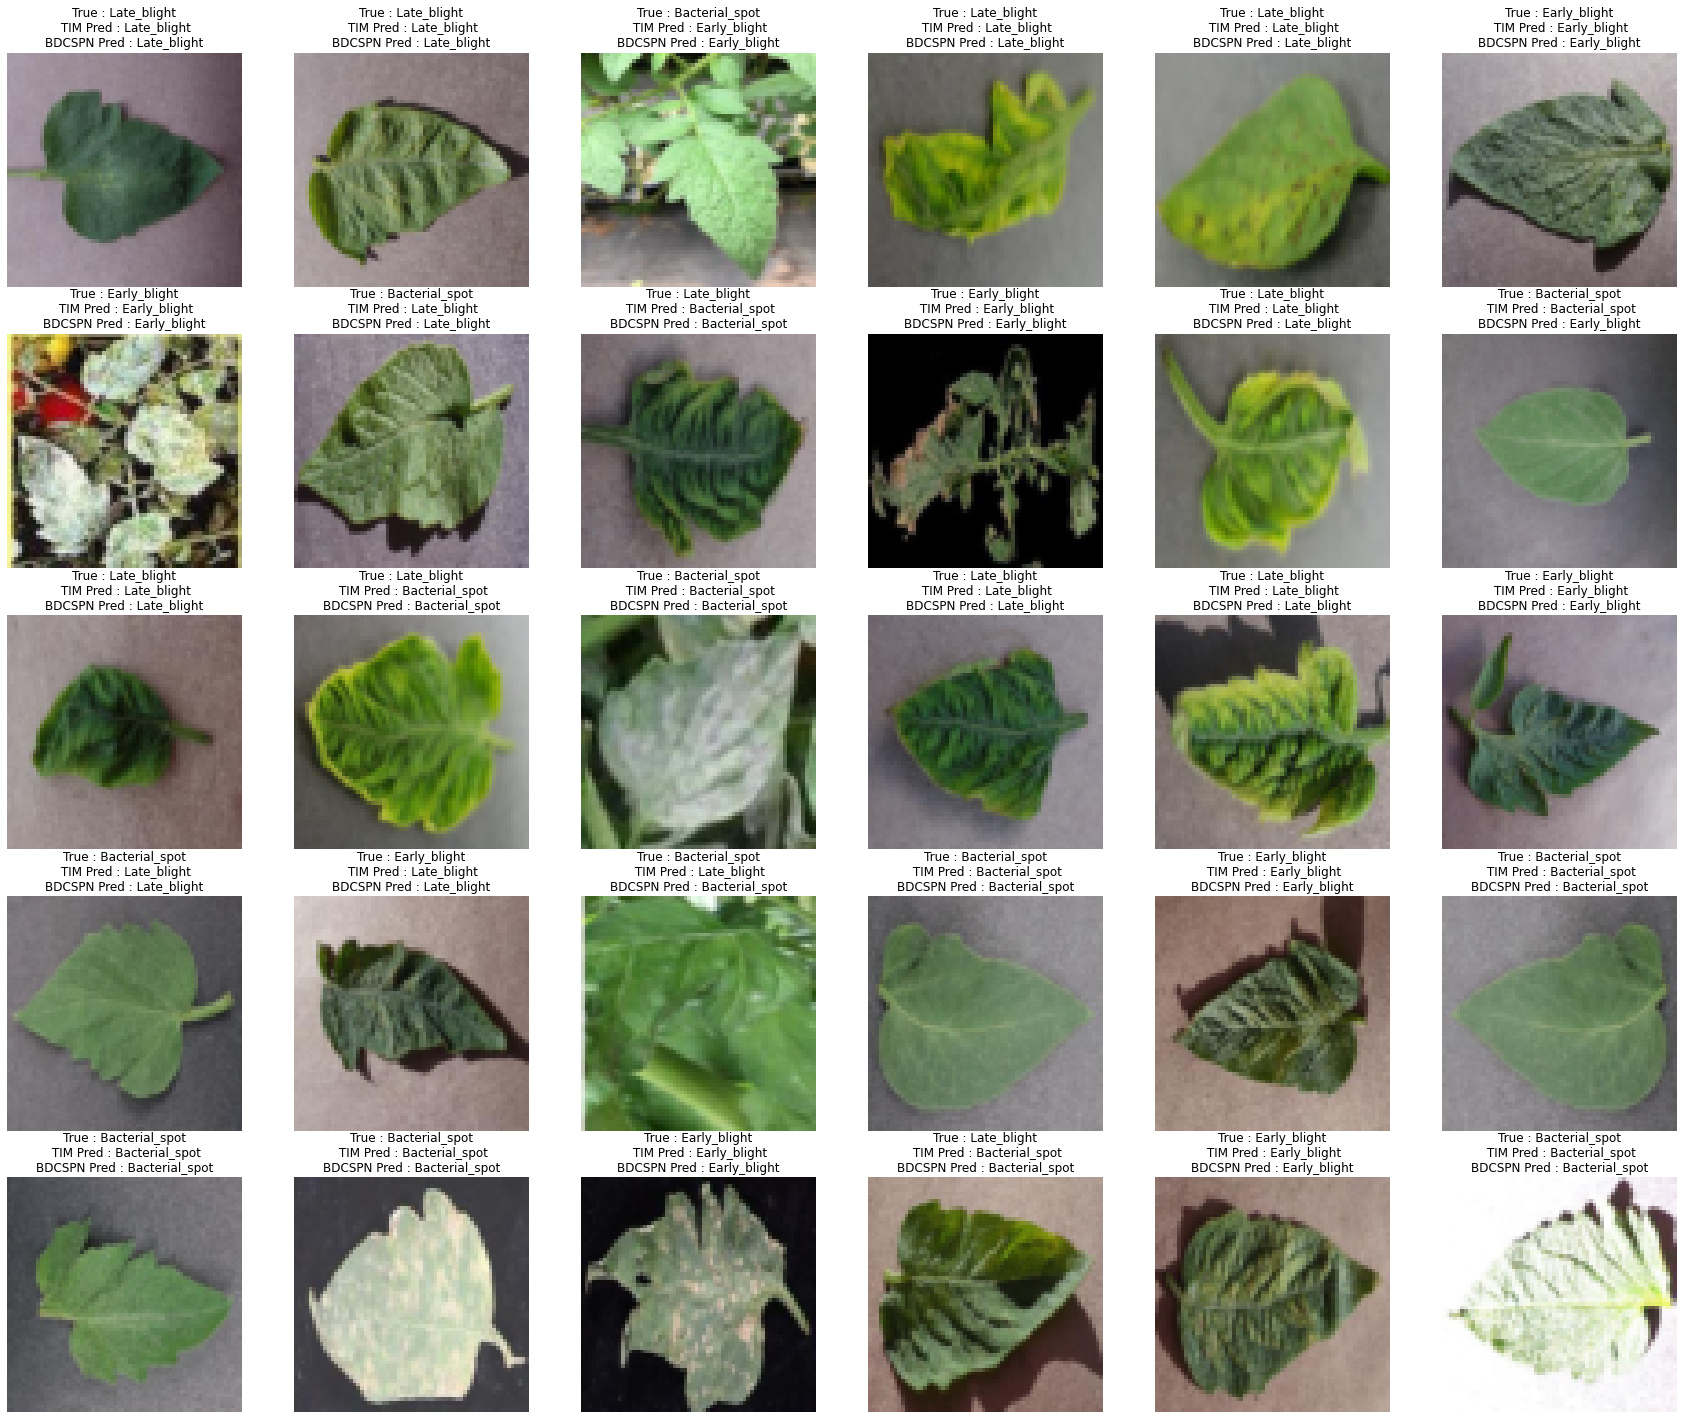

In [17]:
predict(few_shot_classifier,few_shot_classifier2, test_loader, device=DEVICE)